In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import os

import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
#!unzip -q /content/lnu-deep-learn-1-image-classification-2025.zip -d /content/fast_data

#!rm /content/lnu-deep-learn-1-image-classification-2025.zip

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовуємо пристрій: {device}")
if device.type == 'cuda':
    print(f"Назва відеокарти: {torch.cuda.get_device_name(0)}")

data_dir = 'fast_data'
train_dir = os.path.join(data_dir, 'train')

Використовуємо пристрій: cuda
Назва відеокарти: Tesla T4


In [ ]:
os.chdir('/content')

print("Поточна папка:", os.getcwd())
print("Вміст папки:", os.listdir())

Поточна папка: /content
Вміст папки: ['.config', 'drive', 'fast_data', 'sample_data']


In [ ]:
classes_path = os.path.join(data_dir, 'classes.txt')

with open(classes_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

num_classes = len(class_names)

print(f"Кількість класів: {num_classes}")
print(f"Перші 5 класів для прикладу: {class_names[:5]}")

Кількість класів: 100
Перші 5 класів для прикладу: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']


In [ ]:
train_dir = '/content/fast_data/train'

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.Resize((256, 256)),      
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)


num_classes = len(train_dataset.classes)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,       
    shuffle=True,
    num_workers=2,       
    pin_memory=True     
)

print(f"✅ Дані завантажено з: {train_dir}")
print(f"Класів: {num_classes}")
print(f"Зображень для тренування: {len(train_dataset)}")

✅ Дані завантажено з: /content/fast_data/train
Класів: 100
Зображень для тренування: 10911


In [ ]:
print("Завантажуємо ConvNeXt Base...")
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)


num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)


model = model.to(device)

print(f"✅ ConvNeXt Base оновлено. Вхідний розмір фінального шару: {num_ftrs}.")
print("Новий фінальний шар:", model.classifier[-1])

Завантажуємо ConvNeXt Base...
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 212MB/s]


✅ ConvNeXt Base оновлено. Вхідний розмір фінального шару: 768.
Новий фінальний шар: Linear(in_features=768, out_features=100, bias=True)


In [10]:
for param in model.parameters():
    param.requires_grad = True

In [11]:
torch.cuda.empty_cache()

In [12]:
!pip install mlflow
import mlflow
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 145.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.7 MB/s eta 0:00:00


In [ ]:
MLFLOW_TRACKING_URI = "/content/drive/MyDrive/mlruns_butterfly"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print(f"MLflow URI встановлено на: {mlflow.get_tracking_uri()}")

MLflow URI встановлено на: /content/drive/MyDrive/mlruns_butterfly


In [14]:
experiment_name = "ConvNeXt_Tiny_FineTuning"
mlflow.set_experiment(experiment_name)

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/27 17:59:23 INFO mlflow.tracking.fluent: Experiment with name 'ConvNeXt_Tiny_FineTuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/drive/MyDrive/mlruns_butterfly/270599471044790269', creation_time=1764266363336, experiment_id='270599471044790269', last_update_time=1764266363336, lifecycle_stage='active', name='ConvNeXt_Tiny_FineTuning', tags={}>

In [ ]:
checkpoint_path = '/content/drive/MyDrive/butterfly_project/convnext_tiny_butterfly_model.pth'
EPOCHS_PHASE_1 = 15
patience = 5
epochs_without_improvement = 0
best_acc = 0.0
criterion = nn.CrossEntropyLoss()


history = {
    'train_loss': [],
    'train_acc': [],
    'lr': []
}

optimizer_1 = optim.AdamW(model.parameters(), lr=0.0009, weight_decay=0.0001)


scheduler_1 = lr_scheduler.CosineAnnealingLR(
    optimizer_1,
    T_max=EPOCHS_PHASE_1,
    eta_min=1e-6
)

print(f"🔧 Налаштування: AdamW (lr=0.0005, wd=0.01) + CosineAnnealingLR")


mlflow.set_experiment("ConvNeXt_Tiny_FullTraining")

print("\n🚀 ПОЧИНАЄМО ТРЕНУВАННЯ...")

with mlflow.start_run(run_name="Full_Model_AdamW_Cosine") as run:

    mlflow.log_param("epochs", EPOCHS_PHASE_1)
    mlflow.log_param("batch_size", train_loader.batch_size)
    mlflow.log_param("optimizer", "AdamW")
    mlflow.log_param("learning_rate", 0.0009)
    mlflow.log_param("scheduler", "CosineAnnealingLR")
    mlflow.log_param("weight_decay", 0.0001)

    current_optimizer = optimizer_1
    current_scheduler = scheduler_1

    for epoch in range(EPOCHS_PHASE_1):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0


        loop = tqdm(train_loader, desc=f"Епоха {epoch+1}/{EPOCHS_PHASE_1}")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            current_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            current_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        current_scheduler.step()


        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_preds / total_preds
        current_lr = current_optimizer.param_groups[0]['lr']

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['lr'].append(current_lr)

        print(f"🏁 Епоха {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | LR: {current_lr:.6f}")


        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Рекорд! Модель збережено (Acc: {best_acc:.2f}%)")
        else:
            epochs_without_improvement += 1
            print(f"⏹️ Немає покращення: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print(f"🛑 Рання зупинка (Early Stopping) спрацювала!")
            break

print(f"\n🏆 ТРЕНУВАННЯ ЗАВЕРШЕНО! Найкраща точність: {best_acc:.2f}%")

2025/11/27 18:08:17 INFO mlflow.tracking.fluent: Experiment with name 'ConvNeXt_Tiny_FullTraining' does not exist. Creating a new experiment.


🔧 Налаштування: AdamW (lr=0.0005, wd=0.01) + CosineAnnealingLR

🚀 ПОЧИНАЄМО ТРЕНУВАННЯ...


Епоха 1/15: 100%|██████████| 171/171 [03:44<00:00,  1.31s/it, loss=0.383]


🏁 Епоха 1 | Loss: 0.8734 | Acc: 78.87% | LR: 0.000890
✅ Рекорд! Модель збережено (Acc: 78.87%)


Епоха 2/15: 100%|██████████| 171/171 [03:44<00:00,  1.31s/it, loss=0.234]


🏁 Епоха 2 | Loss: 0.2885 | Acc: 91.78% | LR: 0.000861
✅ Рекорд! Модель збережено (Acc: 91.78%)


Епоха 3/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.0809]


🏁 Епоха 3 | Loss: 0.2188 | Acc: 93.12% | LR: 0.000814
✅ Рекорд! Модель збережено (Acc: 93.12%)


Епоха 4/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.13]


🏁 Епоха 4 | Loss: 0.1450 | Acc: 95.54% | LR: 0.000751
✅ Рекорд! Модель збережено (Acc: 95.54%)


Епоха 5/15: 100%|██████████| 171/171 [03:44<00:00,  1.31s/it, loss=0.0856]


🏁 Епоха 5 | Loss: 0.1087 | Acc: 96.68% | LR: 0.000675
✅ Рекорд! Модель збережено (Acc: 96.68%)


Епоха 6/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.0152]


🏁 Епоха 6 | Loss: 0.0648 | Acc: 97.88% | LR: 0.000589
✅ Рекорд! Модель збережено (Acc: 97.88%)


Епоха 7/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.00638]


🏁 Епоха 7 | Loss: 0.0453 | Acc: 98.58% | LR: 0.000497
✅ Рекорд! Модель збережено (Acc: 98.58%)


Епоха 8/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.00147]


🏁 Епоха 8 | Loss: 0.0258 | Acc: 99.23% | LR: 0.000404
✅ Рекорд! Модель збережено (Acc: 99.23%)


Епоха 9/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.00051]


🏁 Епоха 9 | Loss: 0.0153 | Acc: 99.51% | LR: 0.000312
✅ Рекорд! Модель збережено (Acc: 99.51%)


Епоха 10/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.000815]


🏁 Епоха 10 | Loss: 0.0092 | Acc: 99.80% | LR: 0.000226
✅ Рекорд! Модель збережено (Acc: 99.80%)


Епоха 11/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.16]


🏁 Епоха 11 | Loss: 0.0051 | Acc: 99.87% | LR: 0.000150
✅ Рекорд! Модель збережено (Acc: 99.87%)


Епоха 12/15: 100%|██████████| 171/171 [03:44<00:00,  1.31s/it, loss=0.000458]


🏁 Епоха 12 | Loss: 0.0024 | Acc: 99.95% | LR: 0.000087
✅ Рекорд! Модель збережено (Acc: 99.95%)


Епоха 13/15: 100%|██████████| 171/171 [03:44<00:00,  1.31s/it, loss=0.000314]


🏁 Епоха 13 | Loss: 0.0011 | Acc: 99.99% | LR: 0.000040
✅ Рекорд! Модель збережено (Acc: 99.99%)


Епоха 14/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.000442]


🏁 Епоха 14 | Loss: 0.0008 | Acc: 99.99% | LR: 0.000011
⏹️ Немає покращення: 1/5


Епоха 15/15: 100%|██████████| 171/171 [03:43<00:00,  1.31s/it, loss=0.000598]

🏁 Епоха 15 | Loss: 0.0008 | Acc: 99.99% | LR: 0.000001
⏹️ Немає покращення: 2/5

📊 Генерую графіки навчання...


NameError: name 'plt' is not defined


📊 Генерую графіки навчання...


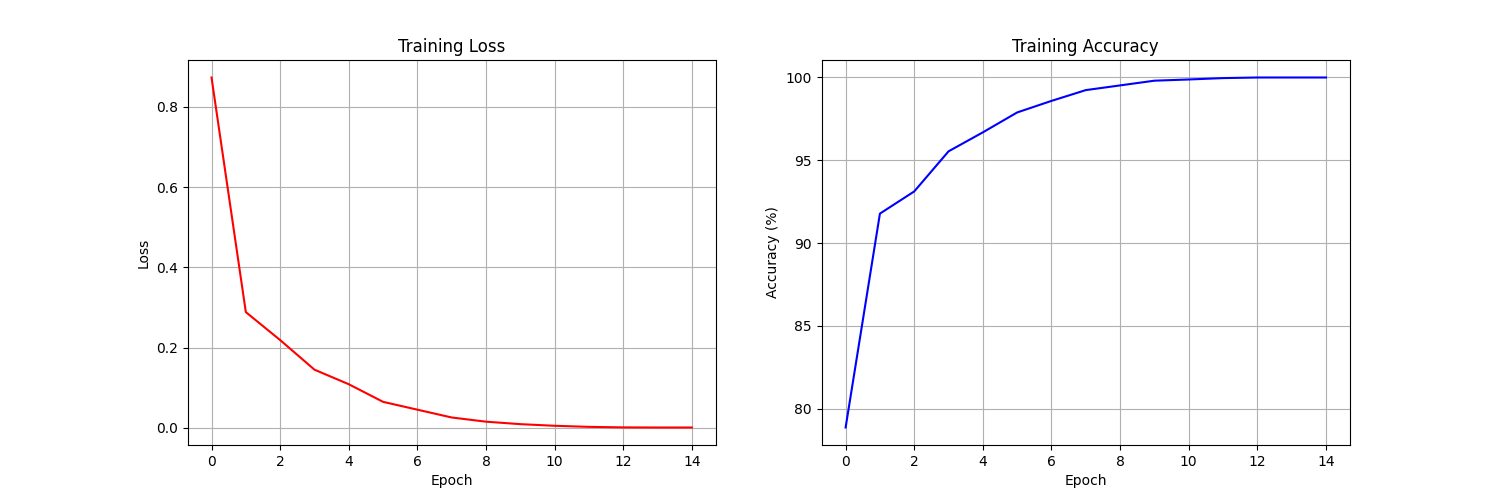

✅ Графіки збережено та відправлено в MLflow.


In [ ]:
with mlflow.start_run(run_name="Full_Model_AdamW_Cosine") as run:
    print("\n📊 Генерую графіки навчання...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss', color='red')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)


    plot_path = "training_metrics.png"
    plt.savefig(plot_path)
    plt.close() 


    mlflow.log_artifact(plot_path)

    from IPython.display import Image
    display(Image(plot_path))

    print(f"✅ Графіки збережено та відправлено в MLflow.")


In [ ]:
checkpoint_path = '/content/drive/MyDrive/butterfly_project/convnext_tiny_butterfly_model.pth'

print("Створення порожньої архітектури ConvNeXt...")

model = models.convnext_tiny(weights=None)

num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)



print("Завантажуємо ваги з чекпойнта...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)

model.eval()

print("🎉 Модель успішно завантажена і готова до передбачень (Inference)!")

Створення порожньої архітектури ConvNeXt...
Завантажуємо ваги з чекпойнта...
🎉 Модель успішно завантажена і готова до передбачень (Inference)!


In [ ]:
loader_to_evaluate = train_loader
class_names = train_dataset.classes

print(f"📊 Починаємо оцінку та логування в MLflow...")
print(f"Експеримент: {mlflow.get_experiment(mlflow.get_experiment_by_name('ConvNeXt_Tiny_FullTraining').experiment_id).name}")


with mlflow.start_run(run_name="Final_Evaluation_Metrics") as run:
    y_pred_list = []
    y_true_list = []

    model.eval()

    print("⏳ Збираємо передбачення...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader_to_evaluate):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred_list.extend(preds.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())


    print("📈 Розрахунок метрик...")

    acc = accuracy_score(y_true_list, y_pred_list)
    print(f"🏆 Accuracy: {acc * 100:.2f}%")

    mlflow.log_metric("final_evaluation_accuracy", acc)

    report = classification_report(y_true_list, y_pred_list, target_names=class_names)

    report_path = "classification_report.txt"
    with open(report_path, "w") as f:
        f.write(report)

    mlflow.log_artifact(report_path)
    print("✅ Звіт класифікації збережено в MLflow.")

    print("🎨 Малювання матриці плутанини...")

    cm = confusion_matrix(y_true_list, y_pred_list)

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Acc: {acc:.2%})')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    cm_path = "confusion_matrix.png"
    plt.savefig(cm_path)

    plt.show()

    mlflow.log_artifact(cm_path)
    print("✅ Матрицю плутанини збережено в MLflow.")

    print("🖼️ Генерація прикладів передбачень...")

    def get_image_for_plot(inp):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp

    inputs, classes = next(iter(loader_to_evaluate))
    inputs = inputs.to(device)


    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    inputs = inputs.cpu()


    fig = plt.figure(figsize=(16, 16))
    num_images_to_show = min(16, len(inputs)) # Про всяк випадок, якщо батч малий

    for i in range(num_images_to_show):
        ax = fig.add_subplot(4, 4, i + 1)

        is_correct = (preds[i] == classes[i])
        true_label = class_names[classes[i]]
        pred_label = class_names[preds[i]]


        title = f"True: {true_label}\nPred: {pred_label}"
        color = 'green' if is_correct else 'red'

        ax.imshow(get_image_for_plot(inputs[i]))
        ax.set_title(title, color=color, fontsize=9)
        ax.axis('off')

    plt.tight_layout()


    viz_path = "predictions_grid.png"
    plt.savefig(viz_path)
    plt.show()

    mlflow.log_artifact(viz_path)
    print("✅ Приклади передбачень збережено в MLflow.")

print("\n🎉 Всі результати успішно завантажені в MLflow!")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class ButterflyTestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name


test_dir = '/content/fast_data/test'


test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ButterflyTestDataset(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # shuffle=False важливо!

print(f"Знайдено тестових зображень: {len(test_dataset)}")

Знайдено тестових зображень: 2728


In [ ]:
try:
    class_names = train_dataset.classes
except NameError:
    print("Відновлюємо список класів...")
    temp_data = datasets.ImageFolder('/content/fast_data/train')
    class_names = temp_data.classes

print(f"Всього класів: {len(class_names)}")


all_ids = []
all_preds = []

model.eval() 
model.to(device)

print("⏳ Починаю передбачення...")

with torch.no_grad(): 
    for inputs, filenames in tqdm(test_loader):
        inputs = inputs.to(device)

        outputs = model(inputs)

        _, predicted_indices = torch.max(outputs, 1)


        for i in range(len(filenames)):
            file_id = os.path.splitext(filenames[i])[0]
            all_ids.append(file_id)

            class_idx = predicted_indices[i].item()
            predicted_label = class_names[class_idx]
            all_preds.append(predicted_label)


submission_df = pd.DataFrame({
    'id': all_ids,
    'label': all_preds
})

csv_path = '/content/drive/MyDrive/butterfly_project/submission_convnext_tiny.csv'
submission_df.to_csv(csv_path, index=False)

print(f"\n✅ Готово! Файл збережено: {csv_path}")
print("Ось перші 5 рядків для перевірки:")
print(submission_df.head())

Всього класів: 100
⏳ Починаю передбачення...


100%|██████████| 86/86 [00:27<00:00,  3.10it/s]


✅ Готово! Файл збережено: /content/drive/MyDrive/butterfly_project/submission_convnext_tiny.csv
Ось перші 5 рядків для перевірки:
                                 id                    label
0  aea4ce0521db4db2bf6be0cb5e47126d  WHITE LINED SPHINX MOTH
1  8429d6c8faa5428bbdd5557fd7e47462            HERCULES MOTH
2  d7dac4265b6c4aff9f9b772e98ef6237                LUNA MOTH
3  33ebf85ba9f44f8686a1c412237ed47c     ARCIGERA FLOWER MOTH
4  2dbfe7eecb4c43afbdfccf1c9e83e9b6          IPHICLUS SISTER
